# Installations

Intstallations required in order to run the code on Google Colab.

In [ ]:
 !sudo apt-get install -y build-essential autoconf libtool pkg-config \
     python3-dev python3-pip python3-numpy git libncurses5-dev \
     libzmq3-dev flex bison
!git clone https://github.com/google/flatbuffers.git
!cd flatbuffers && cmake -G "Unix Makefiles" && make && sudo make install
!pip install cmake==3.15.3


Reading package lists... Done
Building dependency tree       
Reading state information... Done
autoconf is already the newest version (2.69-11).
bison is already the newest version (2:3.0.4.dfsg-1build1).
build-essential is already the newest version (12.4ubuntu1).
flex is already the newest version (2.6.4-6).
libtool is already the newest version (2.4.6-2).
pkg-config is already the newest version (0.29.1-0ubuntu2).
python3-numpy is already the newest version (1:1.13.3-2ubuntu1).
git is already the newest version (1:2.17.1-1ubuntu0.13).
libncurses5-dev is already the newest version (6.1-1ubuntu1.18.04).
python3-dev is already the newest version (3.6.7-1~18.04).
libzmq3-dev is already the newest version (4.2.5-1ubuntu0.2).
python3-pip is already the newest version (9.0.1-2.3~ubuntu1.18.04.5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not up

In [ ]:
!pip install nle
!pip install pyvirtualdisplay
!pip install minihack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gym
import minihack
from minihack import RewardManager
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
from collections import deque
import time
from datetime import datetime
from google.colab import drive
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from collections import namedtuple, deque
import random
import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
reward_manager = RewardManager()
reward_manager.add_kill_event("minotaur", reward=5, repeatable=False)


env = gym.make(
    "MiniHack-Quest-Hard-v0", 
    observation_keys=("glyphs", "chars", "colors",  "colors_crop", "pixel", "pixel_crop", "blstats"),
    reward_manager=reward_manager, savedir="/content/RL/DQN/video",
)


drive.mount('/content/DQN', force_remount=True)

/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:32: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (21, 79)
  "A Box observation space has an unconventional shape (neither an image, nor a 1D vector). "
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:32: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (9, 9)
  "A Box observation space has an unconventional shape (neither an image, nor a 1D vector). "
/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one boo

Mounted at /content/DQN


Functions required to plot a graph of the average reward vs time steps

# Buffer/Memory


In [ ]:
Transition = namedtuple('Transition',('state', 'state_extra_features', 'action', 'next_state', 'next_state_extra_features', 'reward'))

class Buffer(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size): 
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Visited States Functions

Functions used to get extra information from the environment by extracting information from our visited matrix. Finds value of adjacent states to our agents current state and checks how recently they were visited as well if they were visited

In [ ]:
def update_visited(visited, curr_pos):
    visited = visited+1.0
    visited[curr_pos[0]][curr_pos[1]] = 0.0
    for i in range(29, 79):
        visited[3][i] = 0.0
        visited[19][i] = 0.0
    return visited

def adjacent_cells(visited_matrix, currentPos):
    minInd = -1
    minPos = [-1, -1]
    cellInfo = np.zeros(12)
    minVal = 100
    count = 0

    for i in range(2):
        for j in range(2):
            currentAdjacent = [currentPos[0], currentPos[1]]
            
            if j == 0:
              currentAdjacent[i] = currentAdjacent[i]-1
            else:
              currentAdjacent[i] = currentAdjacent[i]+1
            
            if currentAdjacent[0] < 0 or currentAdjacent[1] < 0 or currentAdjacent[0] >= 21 or currentAdjacent[1] >= 79:
                continue
            currentAdjacentValue = min(100, visited_matrix[currentAdjacent[0]][currentAdjacent[1]])   
            if currentAdjacentValue == 100:
                cellInfo[count] = 1.0
            elif currentAdjacentValue < minVal:
                minVal = currentAdjacentValue
                minInd = count
                minPos = currentAdjacent 
            cellInfo[count+8] = currentAdjacentValue/100.0
            count=count+1

    if minInd != -1:
        cellInfo[minInd+4] = 1.0

    return cellInfo, minPos

In [ ]:
def stateInformation(currentObs, TotalSteps, visited_matrix):
    extra_feature_info = np.array([TotalSteps/1000.0, currentObs['blstats'][0], currentObs['blstats'][1]])
    adj_cell_info, recent_vis_cell = adjacent_cells(visited_matrix, (currentObs['blstats'][1], currentObs['blstats'][0]))
    extra_feature_info = np.append(extra_feature_info, adj_cell_info)
    return adj_cell_info, recent_vis_cell
    return extra_feature_info, recent_vis_cell

def stateInputModel(obs):
    stateInput = obs['colors_crop'][3:6,3:6]
    stateInput = np.array(stateInput)
    stateInput = torch.from_numpy(stateInput).to(device).float().unsqueeze(0)
    return stateInput


# Neural Network

Creating our neural network. Descriptions of the network are given in the paper. The forward function is used for two reasons.

*   Determining the next action
*   During batch optimisation



In [ ]:
class CNN(nn.Module):
    def __init__(self, h, w, output):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=1, stride=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=1, stride=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=1, stride=1)
        self.bn3 = nn.BatchNorm2d(32)

        def conv_out(size, kernel_size = 1, stride = 1):
            return (size-(kernel_size - 1)-1)//stride+1

        convw = conv_out(conv_out(conv_out(w)))
        convh = conv_out(conv_out(conv_out(h)))
        linear_input_size = convw * convh * 32 + 12

        self.head = nn.Linear(linear_input_size, output)

    def forward(self, x, y):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        x = x.view(x.size(0), -1)
        x = torch.cat((x,y),1)
        return self.head(x)

def epsilon_greedy(actions, epsilon):
    if random.uniform(0, 1) < epsilon:
        return int(random.uniform(0, len(actions)))
    else:
        return torch.argmax(actions)

# DQN Algorithm

## Hyperparameters

In [ ]:
#List of our hyper-parameters which can be tuned to improve performance
TARGET_UPDATE = 5000
BUFFER_SIZE = 5000
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
LIMITED_ACTION_CHANGE = 50

##Algorithm

In [ ]:
def learn_model(model, target_net, env, num_episodes, gamma, epsilon, l_r, action_list,seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    env.seed(seed)


    #Initialise our model as well as the memory/buffer. 
    #Initialise a few other variables. 
    model.train()
    buffer = Buffer(BUFFER_SIZE)
    mazeExit = 0.0
    lavaExit = 0.0
    stairs = 0.0
    killedMonster = 0.0
    all_acc_rewards = []
    tot_num_steps = 0
    maxReward = -9999
    #Loss function and optimiser. Using Stochastic Gradient Descent optimiser.
    torch.autograd.set_detect_anomaly(False)
    loss_fn = nn.SmoothL1Loss()
    optimizer = torch.optim.SGD(model.parameters(), lr=l_r)
    
    for i in range(num_episodes):
        run_frames = [] 
        acc_reward = 0.0
        curr_observations = env.reset()
        foundMazeExit = False
        foundMazeExitRecent = False
        foundLavaExit = False
        foundStairs = False
        visited_count = 0.0

        #Initialise our Visited matrix.
        visitedStates = np.full((21, 79), 100.0)
        visitedStates = update_visited(visitedStates, (curr_observations['blstats'][1], curr_observations['blstats'][0]))
        visited = np.full((21, 79), False)
        state = stateInputModel(curr_observations).unsqueeze(0)
        state_extra_features_np, recent_visit_cell = stateInformation(curr_observations, tot_num_steps, visited)
        state_extra_features = torch.from_numpy(state_extra_features_np).to(device).float().unsqueeze(0)
        done = False

        while not done:
            pred_action_vals = []
            with torch.no_grad():
                pred_action_vals = model(state, state_extra_features)
            
            #print(curr_observations[1])
            # Get all current state action-values,actions,reward,next state and next state-action values.

            curr_action = epsilon_greedy(pred_action_vals[0], 0.05)
            curr_action_env_ind = action_list[curr_action]
            curr_observations = env.step(curr_action_env_ind)
            curr_reward = curr_observations[1]

            done = curr_observations[2]

            run_frames.append(curr_observations[0]['pixel'])

            #Rewards
            if done:
              curr_reward = 0.0 
            if curr_reward == -0.01:
              curr_reward = -0.66
            elif visited[curr_observations[0]['blstats'][1]][curr_observations[0]['blstats'][0]] >= 100.0:
              curr_reward = 1.0
              visited_count += 1.0
            elif curr_observations[0]['blstats'][1] == recent_visit_cell[0] and curr_observations[0]['blstats'][0] == recent_visit_cell[1]:
              curr_reward = -0.33

            if curr_observations[0]['blstats'][0] == 27 and curr_observations[0]['blstats'][1] == 11 and not foundMazeExit:
              foundMazeExit = True
              foundMazeExitRecent = True
              mazeExit += 1.0
              print('Maze Exit Found')

            if curr_reward == 5:
              killedMonster += 1.0
              print("Killed Monster!")

            if curr_observations[0]['blstats'][0] == 52 and curr_observations[0]['blstats'][1] == 11 and not foundMazeExit:
              curr_reward += 5.0
              foundLavaExit = True
              print("Lava Crossed")
              lavaExit += 1.0

            elif curr_observations[0]['blstats'][0] == 72 and curr_observations[0]['blstats'][1] == 11 and not foundMazeExit:
              curr_reward += 5.0
              foundStairs = True
              print("Found Stairs")
              stairs += 1.0

            if not foundMazeExit:
                next_state_visited_value = min(100.0, visited[curr_observations[0]['blstats'][1]][curr_observations[0]['blstats'][0]])
                curr_reward += float(0.3*(next_state_visited_value/100.0))

            visited = update_visited(visited, (curr_observations[0]['blstats'][1], curr_observations[0]['blstats'][0]))
            curr_action = torch.tensor([[curr_action]], device = device)
            curr_reward = torch.tensor([curr_reward], device = device)
            
            next_state = None
            next_state_extra_features = None
            if not done: 
                  next_state = stateInputModel(curr_observations[0]).unsqueeze(0)
                  next_state_extra_features_np, recent_visit_cell = stateInformation(curr_observations[0], tot_num_steps, visited)
                  next_state_extra_features = torch.from_numpy(next_state_extra_features_np).to(device).float().unsqueeze(0)


            buffer.push(state, state_extra_features, curr_action, next_state, next_state_extra_features, curr_reward)
            BATCH_SIZE = 1
            optimise_model(model, target_net, buffer, 0.0, l_r, optimizer, loss_fn)
            
            state = next_state
            state_extra_features = next_state_extra_features
            just_found_cell_after_maze = False
            
            tot_num_steps += 1
            if tot_num_steps % TARGET_UPDATE == 0:
              target_net.load_state_dict(model.state_dict())

            acc_reward += float(curr_reward[0])
            
        all_acc_rewards.append(acc_reward)
        if i%1 == 0:
            print('Average Reward: ', acc_reward, "Episodes: ",tot_num_steps) 
        
        if(foundMazeExit):
          maxReward = acc_reward
          video_name = "animation"+str(seed)+".mp4"
          fourcc = cv.VideoWriter_fourcc(*'mp4v')
          video = cv.VideoWriter(video_name, fourcc, 30, (run_frames[0].shape[1], run_frames[0].shape[0]))
          for frame in run_frames:
            video.write(frame[:,:,::-1])
          video.release()
        
    return all_acc_rewards, np.array([mazeExit, lavaExit, stairs, killedMonster])

##Optimisation

In [ ]:
BATCH_SIZE = 1
def optimise_model(model, target_net, buffer, gamma,l_r ,optimizer, loss_fn):
    if len(buffer) < BATCH_SIZE:
        return
    transitions = buffer.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    non_final_next_statesL = [s for s in batch.next_state if s is not None]
    if non_final_next_statesL != []:
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        non_final_next_states_extra = torch.cat([s for s in batch.next_state_extra_features if s is not None])
        next_state_values[non_final_mask] = target_net(non_final_next_states, non_final_next_states_extra).max(1)[0].detach()
    state_batch = torch.cat(batch.state)
    state_extra_features_batch = torch.cat(batch.state_extra_features)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_action_values = model(state_batch, state_extra_features_batch).gather(1, action_batch)
    expected_state_action_values = (next_state_values * gamma) + reward_batch
    loss = loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Runs

In [ ]:
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n


def get_avg_reward_for_multiple_runs():
    action_ind_list =  [0,1,2,3,4,5,6,7,20,33,47,49,50,51,52,58,72,75]
    n_runs = 3
    np.random.seed(53)
    seeds = np.random.randint(1000, size=n_runs)
    num_episodes = 100
    avged_rewards = np.zeros(num_episodes)
    all_counts = np.zeros(4)
    total_scores = np.zeros(num_episodes)
    for run in range(n_runs):
      env.reset()
      model = CNN(3, 3, 4).to(device)
      target_net = CNN(3, 3, 4).to(device)
      target_net.load_state_dict(model.state_dict())
      target_net.eval()
      acc_rew, counts = learn_model(model, target_net, env, num_episodes, 0.999, 0.1, 0.001, action_ind_list,seed = int(seeds[run]))
      all_counts = all_counts + counts
      total_scores += acc_rew

    episodes = list(range(num_episodes))
    mean = total_scores / n_runs
    std = np.std(mean)
    window_size = 10
    moving_avg = moving_average(mean, window_size)

    plt.plot(episodes, moving_avg, color='b')
    plt.fill_between(episodes, moving_avg + std, moving_avg - std, facecolor='blue', alpha=0.2)
    plt.ylabel('Average Reward')
    plt.xlabel('Episode #')
    plt.title('DQN averaged over 3 seeds')
    plt.show()

    return all_counts,total_scores,n_runs,episodes

Average Reward:  -409.90600981516764 Episodes:  1000
Average Reward:  -266.43199920095503 Episodes:  2000
Average Reward:  -338.77200686745346 Episodes:  3000
Average Reward:  -141.84799988334998 Episodes:  4000
Average Reward:  -51.59000208135694 Episodes:  5000
Average Reward:  -129.3840081174858 Episodes:  6000
Average Reward:  24.400993367191404 Episodes:  7000
Average Reward:  -194.29200997995213 Episodes:  8000
Average Reward:  74.32699213223532 Episodes:  9000
Average Reward:  -33.575007104314864 Episodes:  10000
Average Reward:  203.1459868149832 Episodes:  11000
Average Reward:  -135.66800958802924 Episodes:  12000
Average Reward:  52.76998952077702 Episodes:  13000
Average Reward:  394.2359838630073 Episodes:  14000
Average Reward:  199.89798469329253 Episodes:  15000
Maze Exit Found
Average Reward:  17.14598749484867 Episodes:  16000
Average Reward:  312.965981926769 Episodes:  17000
Average Reward:  431.66898017702624 Episodes:  18000
Average Reward:  -93.70200763316825 Epi

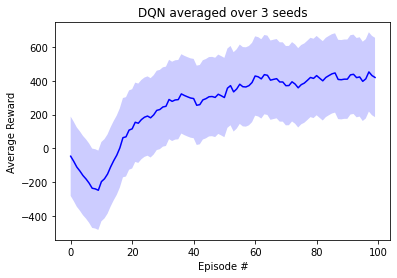

In [ ]:
all_counts,total_scores,n_runs,episodes = get_avg_reward_for_multiple_runs()

In [ ]:
fig = plt.figure(figsize = (10, 5))
subtasks = ["Maze Exit","Crossed lava river","Defeated Demon","Staircase"]
# creating the bar plot
plt.bar(subtasks, all_counts1, color ='maroon',
        width = 0.4)
plt.ylim(0, 100)
plt.xlabel("Sub tasks")
plt.ylabel("Times Completed")
plt.title("Number of Times Subtasks have been completed per 100 episodes")
plt.show()

In [ ]:
import pandas as pd
from google.colab import files
df = pd.DataFrame(total_scores,columns=["Rewards"])
df.to_csv('output.csv') 
files.download('output.csv')